In [83]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs
import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# 1. Final Dataset

In [84]:
train=pd.read_csv('raw_train_daily.csv')
test=pd.read_csv('raw_test_daily.csv')

train=train.iloc[:,1:] #
test=test.iloc[:,1:] #

In [85]:
train=train.drop(labels='Signal',axis=1).dropna() #signal has too many missing values
test=test.drop(labels='Signal',axis=1).dropna() #signal has too many missing values

train.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S',
       'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume',
       'Flag'],
      dtype='object')

# 2. Feature Generation

In [86]:
def feature(train):
    #1. Slope
    train['SPX_1w_chg']=train['SPX']/train['SPX'].shift(-1)-1 #weekly pct change
    train['SPX_2w_chg']=train['SPX']/train['SPX'].shift(-2)-1 

    #2. Spread
    train['Spread_Libor_1YOIS']=train['Libor 1Y']-train['1Y OIS']

    #3. Lag: for comtemporary variables
    l=['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S','AM_L', 'AM_S', 'Lev_L', 'Lev_S']
    newl=['last_'+s for s in l]
    train[newl]=train[l].shift(-1)   #TS ARIMA potential
    train=train.drop(labels=l,axis=1)

    #4. Var

    #5. Cumsum

    #Comments: 1.daily signal 2.time series singal
    
    return train.dropna()

In [87]:
#Benchmark: OLS
train=feature(train)
test=feature(test)

#Since the dataset is already small, train&test set are not splitted yet
X=train.drop(columns = ['Time','AM_NetPos'])
y=train['AM_NetPos']
X_test=test.drop(columns = ['Time','AM_NetPos'])
y_test=test['AM_NetPos']

# 3. LASSO

**3.1 Lasso Model**

In [88]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=10,max_iter=100000).fit(X, y)

In [89]:
print(model.coef_)
print('\nAll varialbes: ',list(X.columns))
print('\nPicked vars: ',list(X.columns[model.coef_==0]))
print('\nLeft out vars: ',list(X.columns[model.coef_!=0]))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  5.10137264e+02  8.88015861e+01 -1.42133728e+03  5.33419468e+00
  7.02990471e+00  2.29478471e+03 -2.64568573e+03 -2.77534879e+02
  7.56756033e+01 -0.00000000e+00 -4.55179028e+01  1.50160034e+01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -2.56497306e-01 -1.14602417e-01 -1.01329368e+00 -3.07504879e-05
 -2.28256510e+02  3.21670704e+05  4.24416866e+03 -0.00000000e+00
 -1.05382319e+02  1.33533313e+02  6.16103782e+00 -5.07546989e+00
  8.90609455e-01 -8.77559461e-01  2.09000141e-01 -2.62583597e-01]

All varialbes:  ['FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX', 'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS', 'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML', 'FF_MOM', 'Lev_NetPos', 'SPY Flows', 'IVV', 'JNK_Volume', 'Flag', 'SPX_1w_chg'

**3.2 Performance**

In [90]:
def evaluate(y,y_pred,title='Result'):
    mse=np.mean((y-y_pred)**2)
    ape=np.mean(np.abs((y-y_pred)/y))
    print(title,':')
    print('MSE is {}'.format(mse))
    print('Average Percentage Error is {}'.format(ape))

In [91]:
#Train
y_pred=model.predict(X)
y_pred_test=model.predict(X_test)

evaluate(y,y_pred,title='Lasso Train')
print('\n')
evaluate(y_test,y_pred_test,title='Lasso Test')

Lasso Train :
MSE is 62262773.13616344
Average Percentage Error is 0.04618291056209291


Lasso Test :
MSE is 186662093.51179442
Average Percentage Error is 0.08931963571908069


**3.3 Residue Plots**

In [92]:
def tsplot(y, lags=None, figsize = (10,8), style = 'bmh',title='Time Series of Log Ret'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax,alpha = 0.05)
        sm.qqplot(y, line = 's', ax=qq_ax)
        qq_ax.set_title('QQ PLot')
        plt.tight_layout()
    return

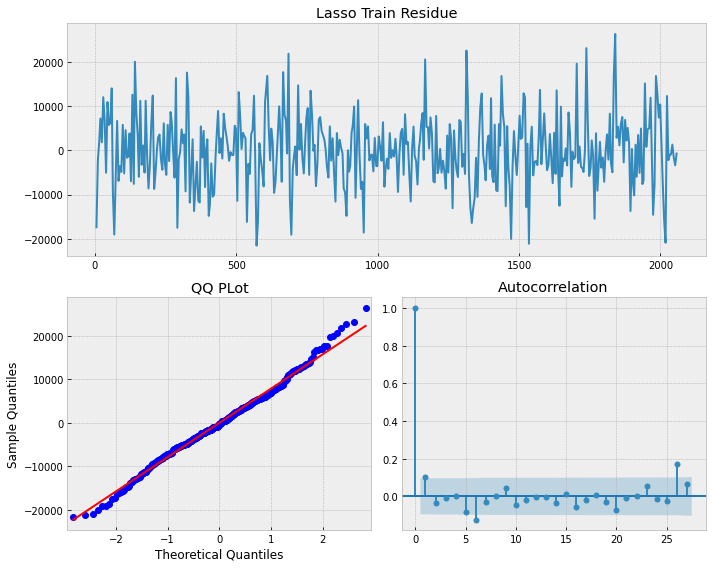

In [93]:
#look at the residue
tsplot(y-y_pred,title='Lasso Train Residue')

Comments:

1. Heavy tail

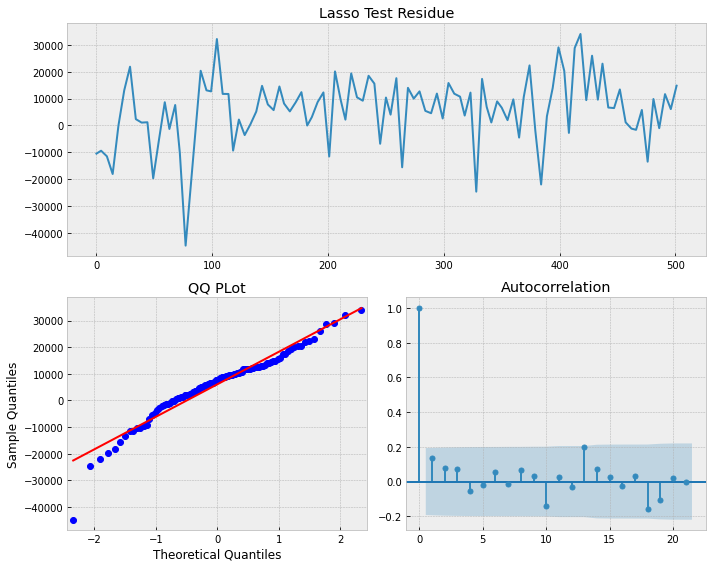

In [94]:
tsplot(y_test-y_pred_test,title='Lasso Test Residue')

# 4. Random Forest

**4.1 RF Model**

In [95]:
from sklearn.ensemble import RandomForestRegressor
model_RF=RandomForestRegressor(n_estimators=20,random_state=0,criterion='mae',
                               min_samples_leaf = 2).fit(X,y)

**4.2 Performance**

In [96]:
y_pred=model_RF.predict(X)
y_pred_test=model_RF.predict(X_test)

evaluate(y,y_pred,title='RF Train')
print('\n')
evaluate(y_test,y_pred_test,title='RF Test')

RF Train :
MSE is 49941067.169101
Average Percentage Error is 0.0415941753319309


RF Test :
MSE is 2248079665.8610735
Average Percentage Error is 0.28096071084591184


**4.3 RF Residue Plot**

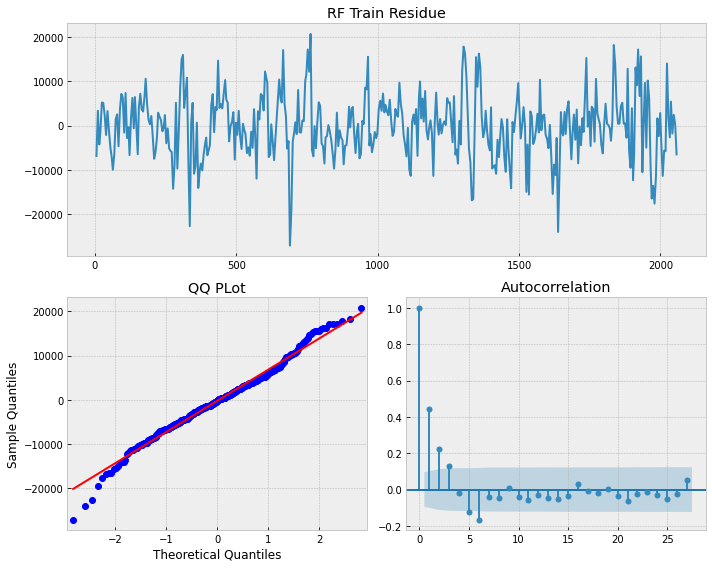

In [97]:
tsplot(y-y_pred,title='RF Train Residue')

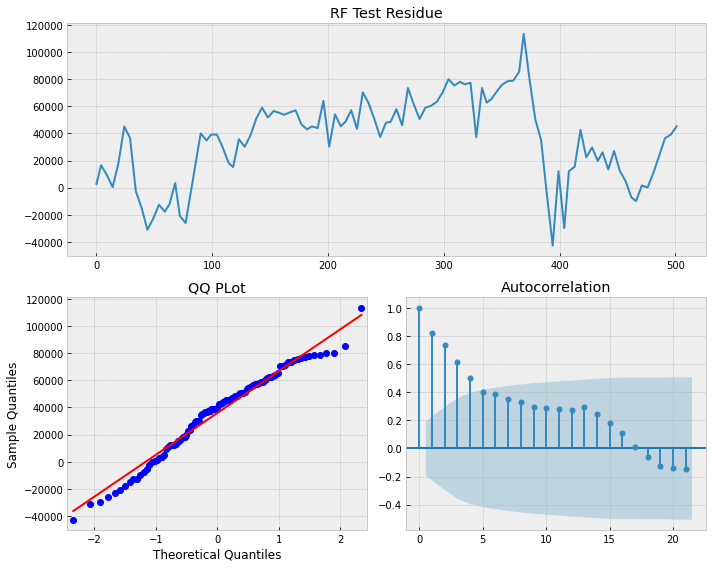

In [98]:
tsplot(y_test-y_pred_test,title='RF Test Residue')